<a href="https://colab.research.google.com/github/PhChLong/ML-DL/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threading

import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision.transforms import v2
from torchvision.transforms.v2 import ToTensor
from torchvision import datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
print(torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
device1 = torch.device("cuda:0")
device2 = torch.device("cuda:1")

2
GPU 0: Tesla T4
GPU 1: Tesla T4


# Data

In [3]:
transform_train = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomCrop(32, padding=4),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomRotation(15),
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
transform_test = v2.Compose([
    ToTensor(),
    v2.Normalize(
        mean=[0.5071, 0.4867, 0.4408],
        std=[0.2675, 0.2565, 0.2761]
    )
])
trainset = datasets.CIFAR100(root = './data', train = True, download= True, transform = transform_train)
testset = datasets.CIFAR100(root = './data', train = False, download= True, transform = transform_test)

train_size = int(0.85 * len(trainset))
valid_size = len(trainset) - train_size
trainset, validset = random_split(trainset, [train_size, valid_size])

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = False)
test_loader = DataLoader(testset, batch_size = 64, shuffle = False)

/usr/local/lib/python3.11/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 169M/169M [00:03<00:00, 54.4MB/s]


# Train function

In [4]:
def train_dataloader_model(
    model, train_loader, valid_loader, optim, loss_fn,
    device=None, max_epochs=100, diff=1e-4, patience=5, scheduler = None, name = None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)

    train_losses = []
    valid_losses = []
    valid_accuracies = []

    valid_loss_min = float("inf")
    patience_counter = 0

    for epoch in range(max_epochs):
        # ----------------------------
        # TRAINING PHASE
        # ----------------------------
        model.train()
        running_train_loss = 0.0

        for X_train, y_train in train_loader:
            X_train, y_train = X_train.to(device), y_train.to(device)

            optim.zero_grad()
            y_pred = model(X_train)
            loss = loss_fn(y_pred, y_train)
            loss.backward()
            optim.step()

            running_train_loss += loss.item()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # ----------------------------
        # VALIDATION PHASE
        # ----------------------------
        model.eval()
        running_valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_valid, y_valid in valid_loader:
                X_valid, y_valid = X_valid.to(device), y_valid.to(device)
                y_pred = model(X_valid)

                # Compute validation loss
                loss = loss_fn(y_pred, y_valid)
                running_valid_loss += loss.item()

                # Compute accuracy
                _, predicted = torch.max(y_pred, 1)
                correct += (predicted == y_valid).sum().item()
                total += y_valid.size(0)

        epoch_valid_loss = running_valid_loss / len(valid_loader)
        epoch_valid_acc = correct / total

        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)

        scheduler.step(epoch_valid_loss)
        # ----------------------------
        # EARLY STOPPING CHECKS
        # ----------------------------
        if epoch > 0 and abs(train_losses[-1] - train_losses[-2]) < diff:
            print(f"{name}|epoch {epoch}: loss diff < {diff} → early convergence.")
            break

        if epoch_valid_loss < valid_loss_min - diff:
            valid_loss_min = epoch_valid_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if epoch %5 ==0:
            print(
                f"{name}|Epoch [{epoch+1}/{max_epochs}] | "
                f"Train Loss: {epoch_train_loss:.4f} | "
                f"Valid Loss: {epoch_valid_loss:.4f} | "
                f"Valid Acc: {epoch_valid_acc*100:.2f}%"
            )

        if patience_counter >= patience:
            print(f"\nEarly stopping: no improvement for {patience} epochs.")
            break

    # ----------------------------
    # PLOTTING BEFORE RETURN
    # ----------------------------
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, valid_losses, label="Valid Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, valid_accuracies, label="Valid Accuracy", color="green")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    return train_losses, valid_losses, valid_accuracies

# ResNet

## Model

In [5]:
class Residual(nn.Module):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               padding=1, stride=strides)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=1,
                                   stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return self.relu(Y)
class ResNet(nn.Module):
    def block(self, num_residuals, in_channel, out_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(in_channel, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(out_channels, out_channels))
            in_channel = out_channels
        return nn.Sequential(*blk)

    def __init__(self, arch, num_classes=100):
        super(ResNet, self).__init__()
        self.b1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
        self.net = nn.Sequential(self.b1)
        for i, b in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.Linear(512, num_classes)))
    def forward(self, x):
        return self.net(x)
class ResNet34(ResNet):
    def __init__(self, num_classes=100):
        super().__init__(((3, 64, 64), (4, 64, 128), (6, 128, 256), (3, 256, 512))
                         , num_classes)

# SE-ResNet

In [6]:
class SEBlock(nn.Module):
    def __init__(self, num_channels, r = 16):
        super().__init__()
        self.GlobalPooling = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(num_channels, num_channels//r)
        self.fc2 = nn.Linear(num_channels//r, num_channels)
        self.net = nn.Sequential(
            self.GlobalPooling,nn.Flatten(), self.fc1, nn.ReLU(), self.fc2, nn.Sigmoid()
        )
    def forward(self, x):
        y = self.net(x)
        y = y[:, :, None, None]
        return x * y
class Residual_with_SEBlock(Residual):
    def __init__(self, in_channels, out_channels, use_1x1conv=False, strides=1):
        super().__init__(in_channels, out_channels, use_1x1conv, strides)
        self.se = SEBlock(out_channels)
    def forward(self, X):
        Y = self.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y = self.se(Y)
        Y += X
        return self.relu(Y)
class SE_ResNet(ResNet):
    def block(self, num_residuals, in_channel, out_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual_with_SEBlock(in_channel, out_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual_with_SEBlock(out_channels, out_channels))
            in_channel = out_channels
        return nn.Sequential(*blk)

    def __init__(self, arch, num_classes=100):
        super().__init__(arch, num_classes)
class SE_ResNet34(SE_ResNet):
    def __init__(self, num_classes=100):
        super().__init__(((3, 64, 64), (4, 64, 128), (6, 128, 256), (3, 256, 512))
                         , num_classes)

## Train model

In [7]:
model1 = ResNet34().to(device1)
optim1 = torch.optim.Adam(model1.parameters(), lr=1e-3, weight_decay = 1e-4)
model2 = SE_ResNet34().to(device2)
optim2 = torch.optim.Adam(model2.parameters(), lr=1e-3, weight_decay = 1e-4)
loss_fn = nn.CrossEntropyLoss()
scheduler1 = ReduceLROnPlateau(optim1, mode='min', factor=0.5, patience=3)
scheduler2 = ReduceLROnPlateau(optim2, mode='min', factor=0.5, patience=3)

In [8]:
total_params1 = sum(p.numel() for p in model1.parameters())
print(f"Total parameters of model1: {total_params1:,}")
total_params2 = sum(p.numel() for p in model2.parameters())
print(f"Total parameters of model2: {total_params2:,}")

Total parameters of model1: 21,335,012
Total parameters of model2: 21,496,208


model1|Epoch [1/100] | Train Loss: 4.1467 | Valid Loss: 3.8881 | Valid Acc: 8.80%
model2|Epoch [1/100] | Train Loss: 4.0787 | Valid Loss: 3.7435 | Valid Acc: 11.59%
model1|Epoch [6/100] | Train Loss: 2.7557 | Valid Loss: 2.7837 | Valid Acc: 29.87%
model2|Epoch [6/100] | Train Loss: 2.6825 | Valid Loss: 2.6762 | Valid Acc: 31.59%
model1|Epoch [11/100] | Train Loss: 2.1733 | Valid Loss: 2.2555 | Valid Acc: 40.52%
model2|Epoch [11/100] | Train Loss: 2.0772 | Valid Loss: 2.1382 | Valid Acc: 43.47%
model1|Epoch [16/100] | Train Loss: 1.8267 | Valid Loss: 2.0465 | Valid Acc: 45.16%
model2|Epoch [16/100] | Train Loss: 1.7438 | Valid Loss: 1.9592 | Valid Acc: 47.53%
model1|Epoch [21/100] | Train Loss: 1.6165 | Valid Loss: 1.9248 | Valid Acc: 49.25%
model2|Epoch [21/100] | Train Loss: 1.5140 | Valid Loss: 1.9169 | Valid Acc: 48.53%
model1|Epoch [26/100] | Train Loss: 1.4537 | Valid Loss: 1.8214 | Valid Acc: 50.81%
model2|Epoch [26/100] | Train Loss: 1.1547 | Valid Loss: 1.6340 | Valid Acc: 55.3

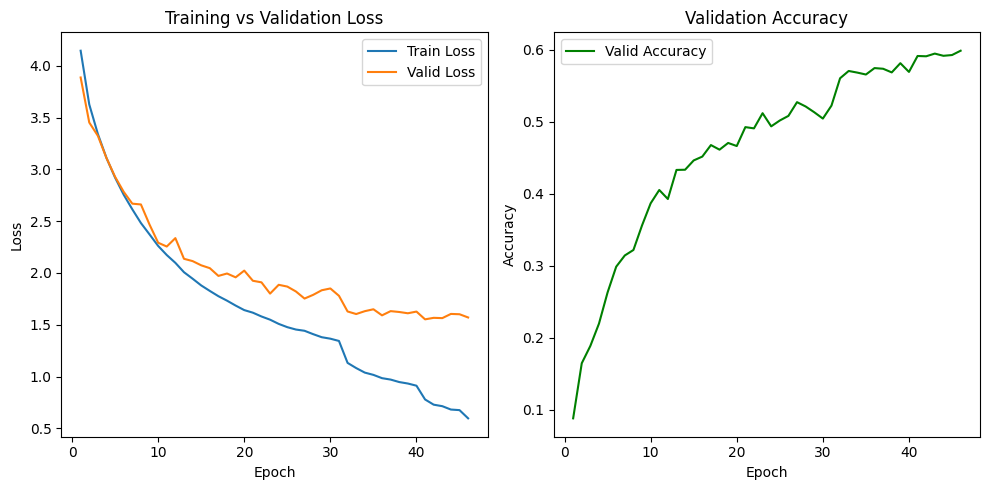

model2|Epoch [46/100] | Train Loss: 0.4845 | Valid Loss: 1.6024 | Valid Acc: 60.40%

Early stopping: no improvement for 5 epochs.


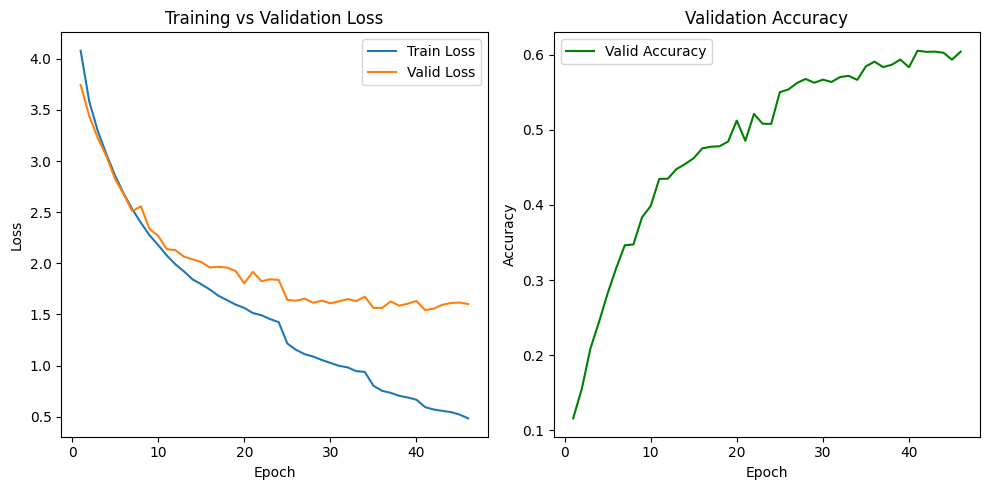

In [9]:
t1 = threading.Thread(
    target=train_dataloader_model,
    args=(model1, train_loader, valid_loader),
    kwargs={
        'optim': optim1,
        'loss_fn': loss_fn,
        'scheduler': scheduler1,
        'name': 'model1'
    }
)

t2 = threading.Thread(
    target=train_dataloader_model,
    args=(model2, train_loader, valid_loader),
    kwargs={
        'optim': optim2,
        'loss_fn': loss_fn,
        'scheduler': scheduler2,
        'name': 'model2'
    }
)
t1.start()
t2.start()

t1.join()
t2.join()

In [10]:
model1.eval()
with torch.no_grad():
    epoch_test_loss = 0.0
    correct = 0
    total = 0

    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device1), y_test.to(device1)
        y_test_pred = model1(X_test)

        # Compute loss
        loss = loss_fn(y_test_pred, y_test)
        epoch_test_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(y_test_pred, 1)
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

    epoch_test_loss /= len(test_loader)
    test_accuracy = correct / total * 100

print(f"Test Loss: {epoch_test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.4612 | Test Accuracy: 63.36%


In [11]:
model2.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device1), y_test.to(device1)
        y_pred = model2(X_test)

        # Compute batch loss
        loss = loss_fn(y_pred, y_test)
        test_loss += loss.item()

        # Compute batch accuracy
        _, predicted = torch.max(y_pred, 1)
        correct += (predicted == y_test).sum().item()
        total += y_test.size(0)

# Average loss per batch
test_loss /= len(test_loader)
test_acc = correct / total * 100

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}%")


Test Loss: 1.4830 | Test Accuracy: 64.02%
